# Going to Jupiter with Python using Jupyter and poliastro

In [1]:
import numpy as np

import astropy.units as u
from astropy.time import Time
from astropy.coordinates import solar_system_ephemeris

from poliastro.bodies import Sun, Earth, Jupiter
from poliastro.twobody import Orbit
from poliastro.maneuver import Maneuver
from poliastro.iod import izzo
from poliastro.plotting import StaticOrbitPlotter
from poliastro.util import norm

solar_system_ephemeris.set("jpl")

<ScienceState solar_system_ephemeris: 'jpl'>

In [2]:
## Initial data
# Links and sources: https://github.com/poliastro/poliastro/wiki/EuroPython:-Per-Python-ad-Astra
date_launch = Time("2011-08-05 16:25", scale="utc")
C_3 = 31.1 * u.km ** 2 / u.s ** 2
date_flyby = Time("2013-10-09 19:21", scale="utc")
date_arrival = Time("2016-07-05 03:18", scale="utc")

In [3]:
# Initial state of the Earth
ss_e0 = Orbit.from_body_ephem(Earth, date_launch)
r_e0, v_e0 = ss_e0.rv()

/home/juanlu/Development/poliastro/poliastro-library/src/poliastro/twobody/orbit.py:395: TimeScaleWarning:

Input time was converted to scale='tdb' with value 2011-08-05 16:26:06.183. Use Time(..., scale='tdb') instead.



In [4]:
r_e0

<Quantity [ 1.02465527e+08, -1.02313505e+08, -4.43533465e+07] km>

In [5]:
v_e0

<Quantity [1847708.49619718, 1594323.36225826,  691089.12249534] km / d>

In [6]:
# State of the Earth the day of the flyby
ss_efly = Orbit.from_body_ephem(Earth, date_flyby)
r_efly, v_efly = ss_efly.rv()

/home/juanlu/Development/poliastro/poliastro-library/src/poliastro/twobody/orbit.py:395: TimeScaleWarning:

Input time was converted to scale='tdb' with value 2013-10-09 19:22:07.182. Use Time(..., scale='tdb') instead.



In [7]:
# Assume that the insertion velocity is tangential to that of the Earth
dv = C_3 ** 0.5 * v_e0 / norm(v_e0)
man = Maneuver.impulse(dv)

In [8]:
# Inner Cruise 1
ic1 = ss_e0.apply_maneuver(man)
ic1.rv()

(<Quantity [ 1.02465527e+08, -1.02313505e+08, -4.43533465e+07] km>,
 <Quantity [2198705.82621214, 1897186.74383867,  822370.88977492] km / d>)

In [9]:
ic1.period.to(u.year)

<Quantity 2.15154736 yr>

/home/juanlu/Development/poliastro/poliastro-library/src/poliastro/twobody/orbit.py:1090: UserWarning:

Frame <class 'astropy.coordinates.builtin_frames.icrs.ICRS'> does not support 'obstime', time values were not returned



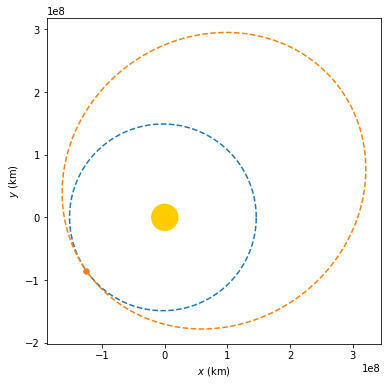

In [10]:
op = StaticOrbitPlotter()

op.plot(ss_e0)
op.plot(ic1);

In [11]:
# We propagate until the aphelion
ss_aph = ic1.propagate(ic1.period / 2)
ss_aph.epoch

<Time object: scale='tdb' format='iso' value=2012-09-01 14:40:01.690>

In [12]:
# Let's compute the Lambert solution to do the flyby of the Earth
time_of_flight = date_flyby - ss_aph.epoch
time_of_flight

<TimeDelta object: scale='tai' format='jd' value=403.1958969055241>

In [13]:
(v_aph, v_fly), = izzo.lambert(Sun.k, ss_aph.r, ss_efly.r, time_of_flight)

In [14]:
# Check the delta-V
norm(v_aph - ss_aph.v)  # Too high!

<Quantity 1.07986596 km / s>

In [15]:
ss_aph_post = Orbit.from_vectors(Sun, ss_aph.r, v_aph, epoch=ss_aph.epoch)
ss_junofly = Orbit.from_vectors(Sun, r_efly, v_fly, epoch=date_flyby)

/home/juanlu/Development/poliastro/poliastro-library/src/poliastro/twobody/orbit.py:1090: UserWarning:

Frame <class 'astropy.coordinates.builtin_frames.icrs.ICRS'> does not support 'obstime', time values were not returned



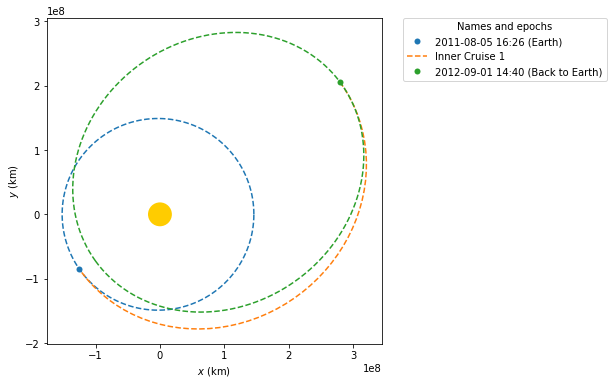

In [16]:
op = StaticOrbitPlotter()

op.plot(ss_e0, label="Earth")
op.plot_trajectory(ic1.sample(50, max_anomaly=180 * u.deg), label="Inner Cruise 1")
op.plot(ss_aph_post, label="Back to Earth");

In [17]:
# And now, go to Jupiter!
ss_j = Orbit.from_body_ephem(Jupiter, date_arrival)
r_j, v_j = ss_j.rv()

/home/juanlu/Development/poliastro/poliastro-library/src/poliastro/twobody/orbit.py:395: TimeScaleWarning:

Input time was converted to scale='tdb' with value 2016-07-05 03:19:08.184. Use Time(..., scale='tdb') instead.



In [18]:
(v_flypre, v_oip), = izzo.lambert(Sun.k, r_efly, r_j, date_arrival - date_flyby)

In [19]:
ss_oip = Orbit.from_vectors(Sun, r_j, v_oip, epoch=date_flyby)

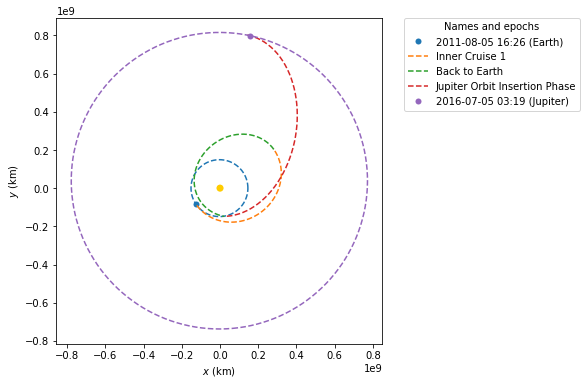

In [20]:
op = StaticOrbitPlotter()

# Plotting approximation, suggestions welcome
op.plot(ss_e0, label="Earth")
op.plot_trajectory(ic1.sample(50, max_anomaly=180 * u.deg), label="Inner Cruise 1")
op.plot_trajectory(
    ss_aph_post.sample(50, min_anomaly=180 * u.deg, max_anomaly=400 * u.deg),
    label="Back to Earth",
)
op.plot_trajectory(
    ss_oip.sample(50, min_anomaly=10 * u.deg, max_anomaly=180 * u.deg),
    label="Jupiter Orbit Insertion Phase",
)
op.plot(ss_j, label="Jupiter");